In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_excel('Scored data_abridged_25 March.xlsx')
df.head()


,Owner Group,Notes,s1_etr,s1_etr_time,s1_svc_rstr,s1_no_prob,s1_hold,s1_cd
0,Global Premium Desk,"Dear Customer,\n\nPlease confirm the current l...",0.0,0,0,0,0.0,1.0
1,Global Premium Desk,"Dear Customer,\n\nPlease check and confirm; be...",0.0,0,0,0,0.0,1.0
2,Global Premium Desk,"Dear Customer, \n\nPlease check and confirm; b...",0.0,0,0,0,0.0,1.0
3,Global Premium Desk,"Dear Customer, \n\nPlease check and confirm; b...",0.0,0,0,0,0.0,1.0
4,Premium SOC,"Dear Harish,\n\nAs discussed over call, we are...",0.0,0,0,0,0.0,1.0


In [3]:
from io import StringIO
col = ['Owner Group', 'Notes']
df = df[col]
df = df[pd.notnull(df['Notes'])]
df.columns = ['Owner Group', 'Notes']
df['category_id'] = df['Owner Group'].factorize()[0]
category_id_df = df[['Owner Group', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Owner Group']].values)
df.head()

,Owner Group,Notes,category_id
0,Global Premium Desk,"Dear Customer,\n\nPlease confirm the current l...",0
1,Global Premium Desk,"Dear Customer,\n\nPlease check and confirm; be...",0
2,Global Premium Desk,"Dear Customer, \n\nPlease check and confirm; b...",0
3,Global Premium Desk,"Dear Customer, \n\nPlease check and confirm; b...",0
4,Premium SOC,"Dear Harish,\n\nAs discussed over call, we are...",1


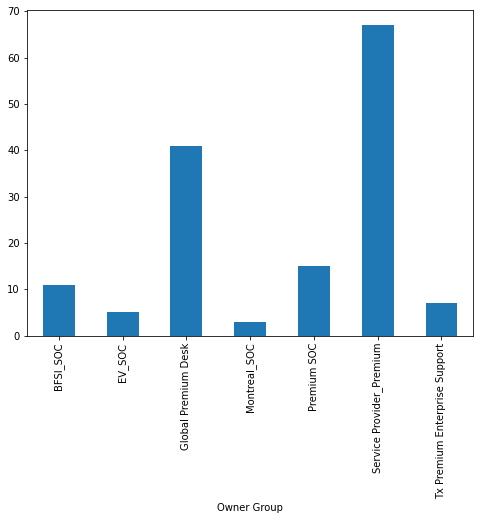

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Owner Group').Notes.count().plot.bar(ylim=0)
plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Notes).toarray()
labels = df.category_id
features.shape

(149, 367)

In [6]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Owner_Group,category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Owner_Group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'BFSI_SOC':
  . Most correlated unigrams:
. interface
. location
  . Most correlated bigrams:
. wan ip
. kindly share
# 'EV_SOC':
  . Most correlated unigrams:
. subject
. basis
  . Most correlated bigrams:
. customer check
. thanks regards
# 'Global Premium Desk':
  . Most correlated unigrams:
. utilization
. sites
  . Most correlated bigrams:
. sites observing
. confirm sites
# 'Montreal_SOC':
  . Most correlated unigrams:
. number
. reach
  . Most correlated bigrams:
. check confirm
. dear team
# 'Premium SOC':
  . Most correlated unigrams:
. number
. configuration
  . Most correlated bigrams:
. configuration issue
. local customer
# 'Service Provider_Premium':
  . Most correlated unigrams:
. mail
. number
  . Most correlated bigrams:
. dear team
. team update
# 'Tx Premium Enterprise Support':
  . Most correlated unigrams:
. internal
. shortly
  . Most correlated bigrams:
. internal team
. team working


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Notes'], df['Owner Group'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [20]:
print(clf.predict(count_vect.transform(["We will try again after 10 mins"])))

['Global Premium Desk']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


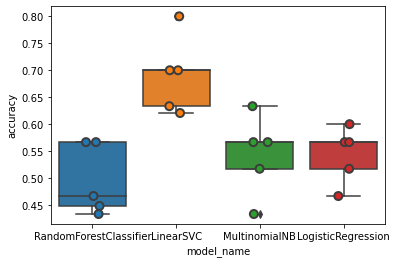

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.690805
LogisticRegression        0.543448
MultinomialNB             0.543448
RandomForestClassifier    0.496322
Name: accuracy, dtype: float64

In [11]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[ 5  0  6  0  0  1  0]
 [ 2  5  0  0  0  0  0]
 [ 4  0 15  0  1  0  0]
 [ 1  1  1  1  0  0  0]
 [ 0  0  1  0  3  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  1]]


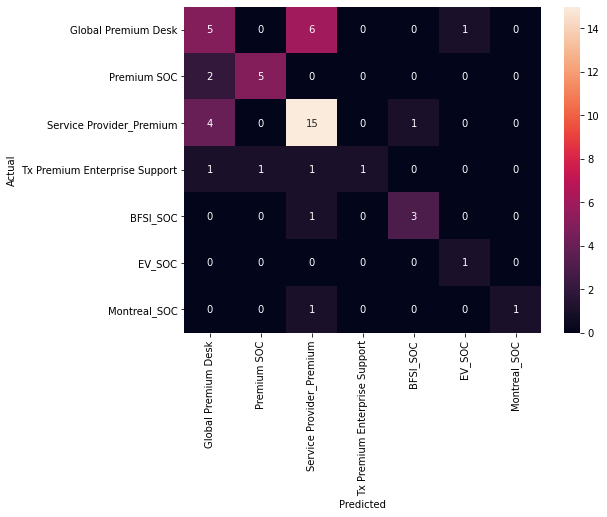

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['Owner Group'].values, yticklabels=category_id_df['Owner Group'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Owner Group', 'Notes']])
      print('')

'Global Premium Desk' predicted as 'Service Provider_Premium' : 6 examples.


,Owner Group,Notes
133,Global Premium Desk,"Hi Team,\nMeanwhile we are verifying media and..."
84,Global Premium Desk,We are resolving this ticket and the link is u...
43,Global Premium Desk,\n\nCAUTION: This email originated from outsid...
134,Global Premium Desk,"Hi Team,\nRequest you to share source based fo..."
51,Global Premium Desk,"Dear Customer,\n\nWe are seeing intermittently..."
146,Global Premium Desk,"Hi Sunildutt,\n\nMain path is UP and stable.\n..."


In [14]:
model.fit(features, labels)


LinearSVC()

In [15]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'BFSI_SOC':
  . Top unigrams:
       . case
       . interface
  . Top bigrams:
       . power status
       . kindly share
# 'EV_SOC':
  . Top unigrams:
       . subject
       . observations
  . Top bigrams:
       . customer check
       . thanks regards
# 'Global Premium Desk':
  . Top unigrams:
       . time
       . utilization
  . Top bigrams:
       . request share
       . confirm current
# 'Montreal_SOC':
  . Top unigrams:
       . reach
       . number
  . Top bigrams:
       . keeping case
       . current link
# 'Premium SOC':
  . Top unigrams:
       . cable
       . configuration
  . Top bigrams:
       . local customer
       . configuration issue
# 'Service Provider_Premium':
  . Top unigrams:
       . getting
       . checked
  . Top bigrams:
       . end issue
       . team update
# 'Tx Premium Enterprise Support':
  . Top unigrams:
       . shortly
       . internal
  . Top bigrams:
       . internal team
       . team working


In [27]:
texts = ["Dear Customer,Please confirm the current latency and optimal latency to be observed on circuit.",
         "Dear customer,We are checking our media as per your request, will share our end observation in next 90 minutes.",
         "Dear Customer,We are observing alarm is showing clean please check and confirm link status.",
        "I have no money to pay my tuition","I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request",
        "We will try again after 10 mins",
        "if no problem found",
        "The time for ETR has to be extracted from the email"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Dear Customer,Please confirm the current latency and optimal latency to be observed on circuit."
  - Predicted as: 'Global Premium Desk'

"Dear customer,We are checking our media as per your request, will share our end observation in next 90 minutes."
  - Predicted as: 'Global Premium Desk'

"Dear Customer,We are observing alarm is showing clean please check and confirm link status."
  - Predicted as: 'Service Provider_Premium'

"I have no money to pay my tuition"
  - Predicted as: 'Service Provider_Premium'

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Service Provider_Premium'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Service Provider_Premium'

"I can't get the money out of the country."
  - Predicted as: 'Service Provider_Premium'

"I have no money to pay my tuition"
  - Predicted as: 'Service Provider_Premium'

"Coinbase closed my acc

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Owner Group'].unique()))

                               precision    recall  f1-score   support

          Global Premium Desk       0.42      0.42      0.42        12
                  Premium SOC       0.83      0.71      0.77         7
     Service Provider_Premium       0.62      0.75      0.68        20
Tx Premium Enterprise Support       1.00      0.25      0.40         4
                     BFSI_SOC       0.75      0.75      0.75         4
                       EV_SOC       0.50      1.00      0.67         1
                 Montreal_SOC       1.00      0.50      0.67         2

                     accuracy                           0.62        50
                    macro avg       0.73      0.63      0.62        50
                 weighted avg       0.66      0.62      0.61        50

